### 1a)

In [26]:
# load in the source data
options(jupyter.plot_mimetypes = 'image/png')
set.seed(123)
library(geoR)
library(sp)
library(rgdal)
library(maptools)
library(splancs)
library(spatstat)
library(lattice)
library(SpatialEpi)
library(sp)
library(Matrix)
library(splines)
library(RColorBrewer)
library(maps)
library(maptools)
library(classInt)
library(ggplot2)
library(foreign)
data("ca20")

variog: computing omnidirectional variogram


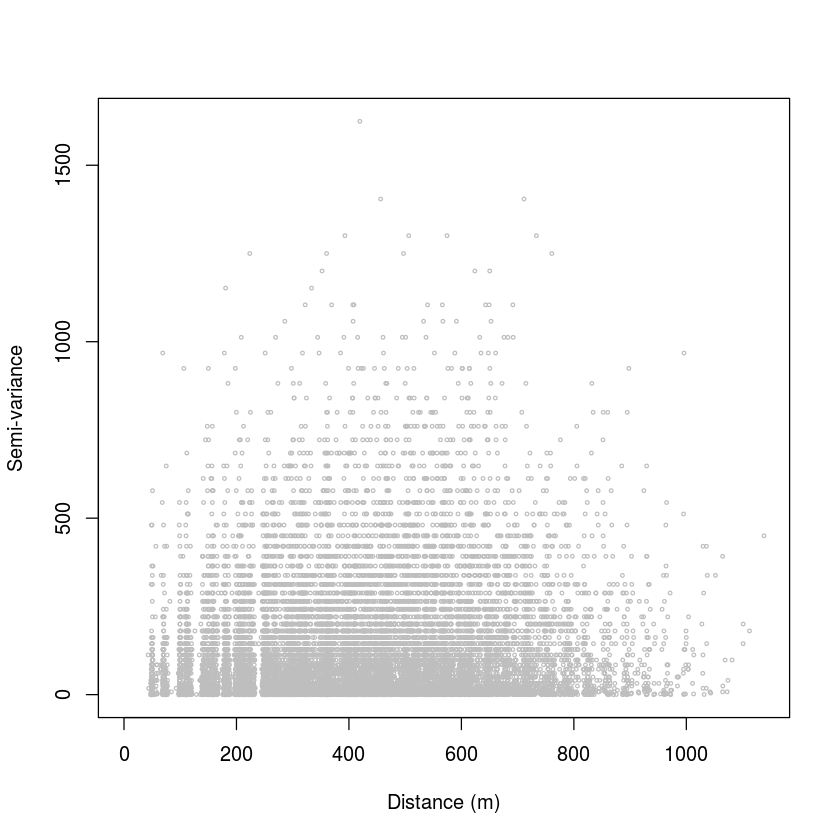

In [2]:
cloudca20 <- variog(ca20, option = "cloud")
plot(cloudca20, ylab = "Semi-variance", xlab = "Distance (m)",
     col = "grey", cex = 0.4)

variog: computing omnidirectional variogram


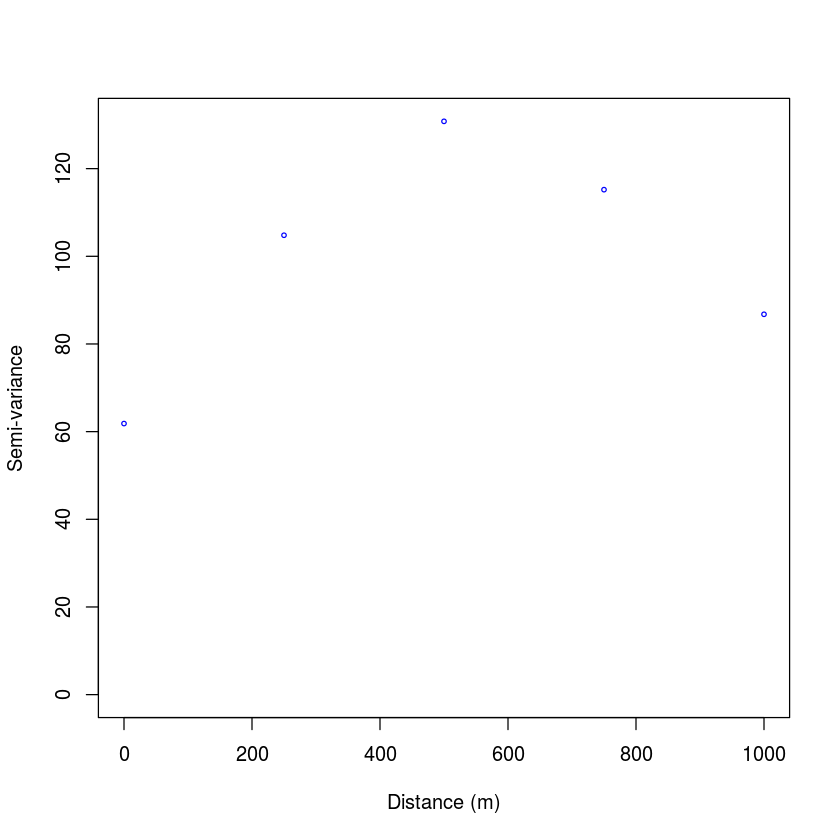

In [3]:
binca20 <- variog(ca20, uvec = seq(0,5000, 250), 
                  trend = ~ca20$covariate$altitude)
plot(binca20, ylab = "Semi-variance", xlab = "Distance (m)",
     cex = 0.5, col = "blue")

### 1b)

variog.env: generating 99 simulations by permutating data values
variog.env: computing the empirical variogram for the 99 simulations
variog.env: computing the envelops


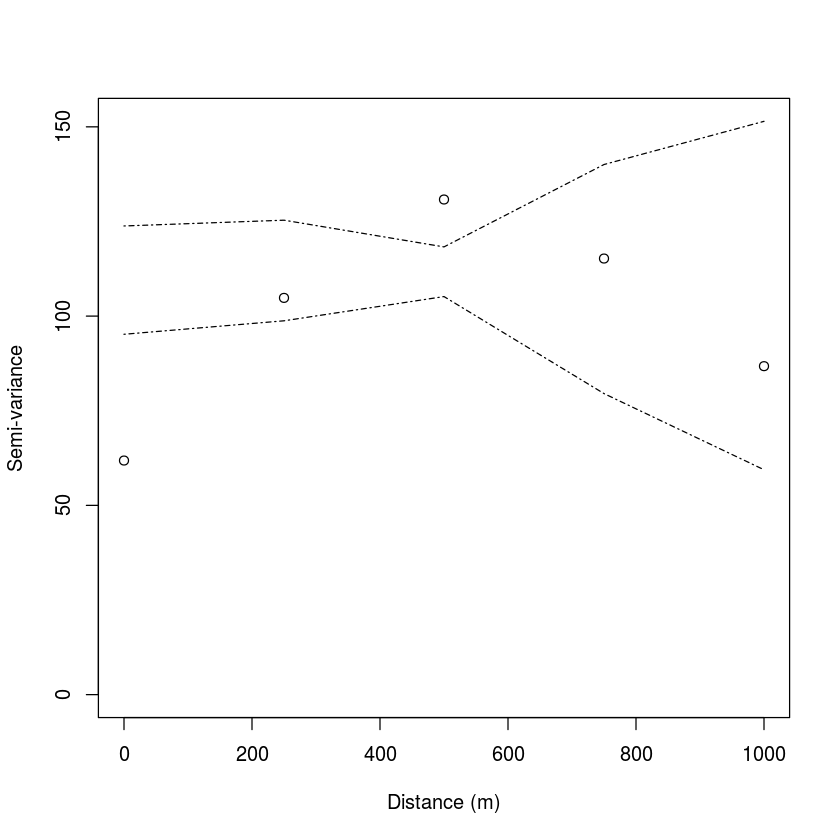

In [4]:
ca20.env <- variog.mc.env(ca20, obj = binca20)
plot(binca20, env = ca20.env, xlab = "Distance (m)",ylab = "Semi-variance")

### 1c)

In [5]:
olsfit <- variofit(binca20, ini = c(50, 50), weights = "equal")
olsfit

variofit: covariance model used is matern 
variofit: weights used: equal 
variofit: minimisation function used: optim 


variofit: model parameters estimated by OLS (ordinary least squares):
covariance model is: matern with fixed kappa = 0.5 (exponential)
parameter estimates:
  tausq sigmasq     phi 
61.7763 48.4090 88.4765 
Practical Range with cor=0.05 for asymptotic range: 265.052

variofit: minimised sum of squares = 1011.59

In [6]:
mlfit <- likfit(ca20, ini = c(50, 50), trend = ~ca20$covariate$altitude, 
                messages=FALSE)
remlfit <- likfit(ca20, ini = c(50,50), lik.method = "RML", trend = ~ca20$covariate$altitude, 
                  messages=FALSE)
print("maximum likelihood")
mlfit$parameters.summary
print("restricted maximum likelihood")
remlfit$parameters.summary

[1] "maximum likelihood"


,status,values
beta0,estimated,39.1632
beta1,estimated,2.0209
tausq,estimated,15.997
sigmasq,estimated,128.1412
phi,estimated,147.0894
kappa,fixed,0.5
psiA,fixed,0
psiR,fixed,1
lambda,fixed,1


[1] "restricted maximum likelihood"


,status,values
beta0,estimated,40.151
beta1,estimated,1.8781
tausq,estimated,18.9967
sigmasq,estimated,149.9804
phi,estimated,191.6871
kappa,fixed,0.5
psiA,fixed,0
psiR,fixed,1
lambda,fixed,1


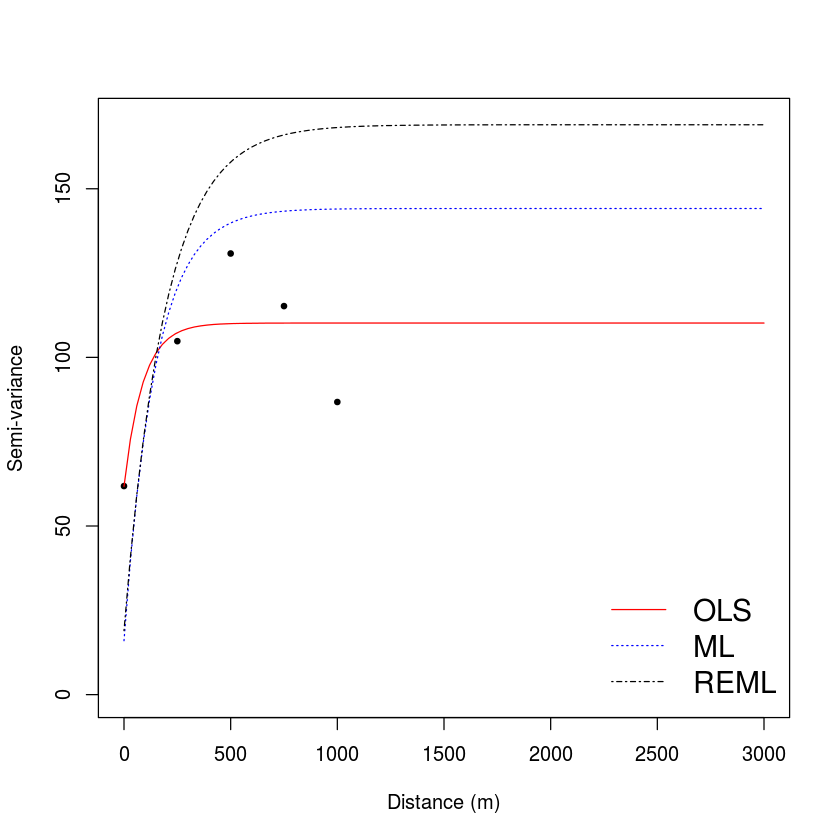

In [7]:
plot(binca20, max.dist = 3000, xlab = "Distance (m)",ylab = "Semi-variance", 
     pch = 19, cex = 0.6, ylim= c(0,170))
lines(olsfit, max.dist = 3000, col = "red")
lines(mlfit, max.dist = 3000, lty = 3, col = "blue")
lines(remlfit, max.dist = 3000, lty = 4, col = "black")
legend("bottomright", legend = c("OLS", "ML", "REML"), lty = c(1, 3, 4), bty = "n", 
       col = c("red", "blue", "black"), cex = 1.5)

### 1d) Kriging

In [8]:
lmfit <- lm(ca20$data ~ ca20$covariate$altitude)
detrend <- as.geodata(cbind(ca20$coords, lmfit$residuals))
mlfit2 <- likfit(detrend, ini = c(50, 50), messages=FALSE)

In [9]:
pred.grid <- expand.grid(seq(4800, 6000,l = 51), seq(4800, 5800, l = 51))
kc <- krige.conv(detrend, loc = pred.grid, krige = krige.control(obj.m = mlfit2))

krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


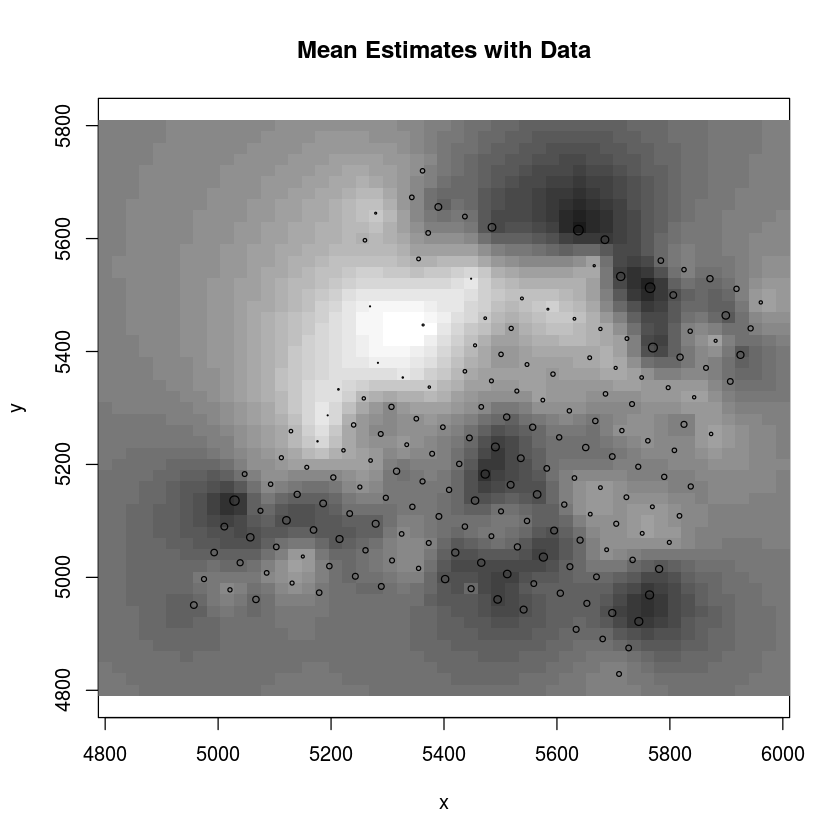

In [10]:
image(kc, loc=pred.grid, val=kc$predict, col=gray(seq(1,.1,l=30)),
      xlab="x",ylab="y", main="Mean Estimates with Data")
symbols(detrend$coords[,1], detrend$coords[,2],
        circles=(detrend$data-min(detrend$data))/1,
        add=TRUE, inches=0.04)

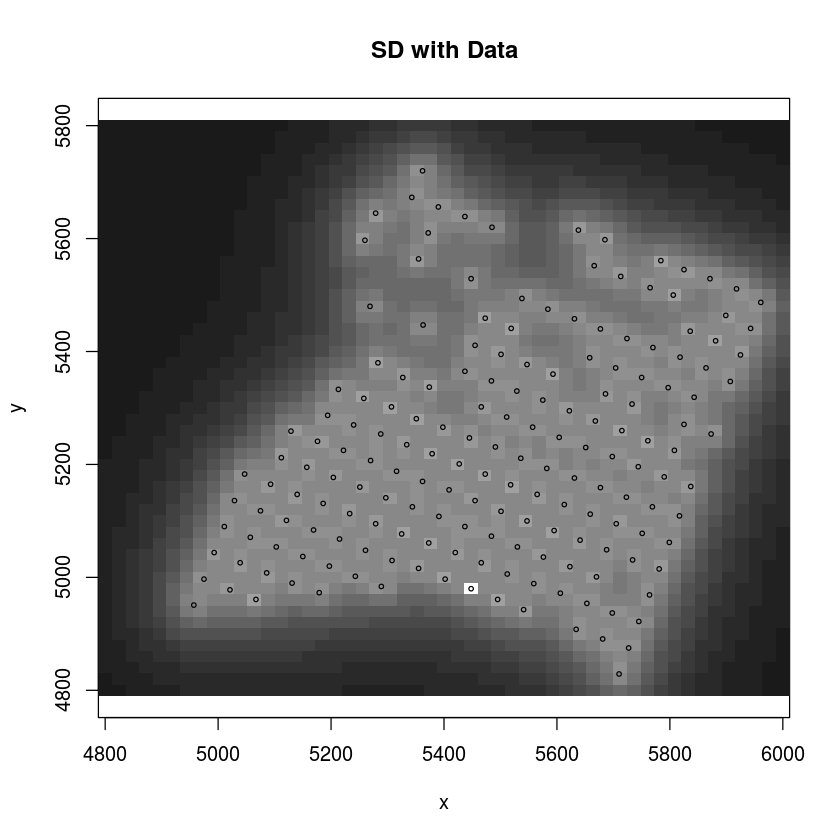

In [11]:
image(kc, val=sqrt(kc$krige.var), col=gray(seq(1,.1,l=30)), 
      xlab="x", ylab="y", main="SD with Data")
points(detrend$coords[,1], detrend$coords[,2], cex=.5)

### 2a)

In [12]:
setwd("../hw1")
source("AlaskaScript.R", echo=FALSE)
setwd("../hw4")
alaska <- subset(x, ASTHMA != -999)

In [13]:
spasthma <- readOGR(".", "spasthma", verbose = FALSE)
spbdry <- readOGR(".", "spbdry", verbose = FALSE)
spsrc <- readOGR(".", "spsrc", verbose = FALSE)
sproads <- readOGR(".", "sproads", verbose = FALSE)

In [21]:
load("../hw3/USA_adm2.RData") # From http://gadm.org/
al_poly<- gadm[which(gadm$NAME_1=="Alaska"), ]

## Make a polygon with the same coordinates as the penn_data has 
al_poly <- as(al_poly, "SpatialPolygons")
projection <- CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
alaska_poly <- spTransform(al_poly, projection)
#tmp <- as(al_poly, "SpatialPolygons")
#alaska_poly  <- latlong2grid(tmp)
alaska_poly$ID <- 1:length(al_poly)

In [22]:
pointdf <- SpatialPointsDataFrame(coords=alaska[,c("X_COORD", "Y_COORD")],
                                  data=alaska[,c("MOLD", "ASTHMA")])

In [23]:
polygondf <- fortify(alaska_poly)
uganda_point_plot <- ggplot() +
    geom_polygon(data=polygondf, aes(x=long,y=lat,group=group), 
                 fill='grey90', color='grey') +
    geom_point(data=alaska[,c("X_COORD", "Y_COORD")], 
               aes(x=X_COORD, y=Y_COORD), col="red",pch=20,cex=.03) +
    coord_fixed() +
    ggtitle("Households") +
    theme_minimal() 

Regions defined for each Polygons


In [24]:
head(polygondf)

,long,lat,order,hole,piece,id,group
1,-159.8998,56.49451,1,FALSE,1,173,173.1
2,-159.9004,56.32111,2,FALSE,1,173,173.1
3,-159.8064,56.32068,3,FALSE,1,173,173.1
4,-159.8065,56.23389,4,FALSE,1,173,173.1
5,-159.8066,56.14728,5,FALSE,1,173,173.1
6,-159.8067,55.97412,6,FALSE,1,173,173.1


In [25]:
head(alaska)

,INTERSECTI,NEW_ID,X_COORD,Y_COORD,BATCHRDA,V2,V3,GENDER,YEARS,MONTHS,WHITE,BLACK,NATIVE,ASIAN,HISPANIC,PACISLAN,OTHER,COUGH,WHEEZE,MEDS,ILLNESSS,PARENTAS,ASTHMA,V20,V21,PEOPLE,TIME,SMOKE,MOTHER,FATHER,SOMEONE,WHO,CIGARRET,PETS,MOLD,HOMETYPE,FORCEDAI,HWBB,OIL,WOOD,ELECTRIC,KEROSENE,HEATERS,WHAT,COCKROAC,HUMIDIFI,Q19STEAM,Q19CMIST,Q19UNK,GARAGE,CARS,ENGINES,GASOLINE,INCOME,SCH_ID,BUFF_ID,X_COORD.1,Y_COORD.1,COUNT,TRAFFIC_DOSE
1,LAKE OTIS & LORE,367,529682.9,2613240,09/18/01,LAKE OTIS PRKWY,LORE RD,0,4,11,1,0,0,0,0,0,0,1,0,0,1,0,0,-999,-999,4,1,1,1,1,0,-999,0,0,3,2,0,1,0,0,0,0,0,-999,3,2,1,0,0,0,-999,-999,-999,2,AL,11125,529682.9,2613240,3,4867038
2,LAKE OTIS & LORE,366,529682.9,2613240,09/18/01,LAKE OTIS,LORE,0,6,11,0,0,0,1,0,0,0,1,0,0,1,1,0,-999,-999,7,4,0,0,0,0,-999,0,0,3,4,1,0,0,0,0,0,0,-999,3,1,0,1,0,1,1,1,0,3,AL,11125,529682.9,2613240,3,4867038
3,88TH & LAKE OTIS,365,529698.7,2609281,09/18/01,88TH,LAKE OTIS,1,5,11,0,0,1,0,0,0,0,0,0,0,2,2,0,-999,-999,9,2,0,0,0,0,-999,0,5,3,4,1,0,0,0,0,0,0,-999,3,2,0,0,0,-999,0,1,0,3,AL,11123,529698.7,2609281,3,4337091
4,LAKE OTIS & ABBOTT,364,529704.2,2607961,09/18/01,LAKE OTIS,ABBOTT,1,-999,-999,0,0,1,0,0,0,0,1,0,0,1,0,0,-999,-999,4,1,0,0,0,0,-999,0,2,3,4,0,0,0,0,1,0,0,-999,3,3,0,0,0,0,-999,-999,-999,3,AL,11122,529704.2,2607961,5,5446692
5,88TH & LAKE OTIS,363,529698.7,2609281,09/18/01,88TH,LAKE OTIS,1,5,10,0,0,1,0,0,0,0,1,0,0,1,1,0,-999,-999,8,1,1,1,1,0,-999,1,0,3,4,1,0,0,0,0,0,0,-999,3,3,0,0,0,1,0,0,0,3,AL,11123,529698.7,2609281,3,4337091
6,DE ARMOUN & HILLSIDE,362,545600.1,2594805,09/18/01,DEARMOUN,HILLSIDE,0,5,1,1,0,0,0,0,0,0,1,0,0,2,0,0,-999,-999,3,1,1,1,1,0,-999,2,1,3,4,0,1,0,0,0,0,0,-999,3,3,0,0,0,1,-999,-999,0,-999,AL,11120,545600.1,2594805,2,397584
